In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import matplotlib.colors as mcolors
import napari
import pandas as pd
from skimage.measure import label as skimage_label, regionprops_table
from laptrack import LapTrack
from laptrack import datasets
from laptrack.data_conversion import convert_split_merge_df_to_napari_graph
import os
from patchify import patchify  
import random
from scipy import ndimage
import datasets
from skimage.transform import resize
from skimage import exposure
from datasets import Dataset
from PIL import Image
from transformers import SamModel, SamConfig, SamProcessor
import torch
import cv2
from skimage import measure
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import os
from tqdm import tqdm
import time
import pickle
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from datasets import Dataset as HFDataset
import random
from transformers import SamConfig, SamProcessor, SamModel


## Fine-tuning SAM using custom data 

### Prepare the training dataset 

In [4]:
# Define the relative path to the intensity folder
intensity_folder = os.path.join("embryo_data_97", "intensity")

# Initialize an empty list to hold the image slices
images = []

# Loop through the image files t0001 to t0097
for i in range(1, 98):
    filename = os.path.join(intensity_folder, f't{i:04d}_DNA.tif')
    img = tifffile.imread(filename)  # Load the image
    images.append(img)  # Append the image to the list

# Concatenate the images along the first axis
images = np.concatenate(images, axis=0)

# Verify the shape of the concatenated images
print(images.shape)

(3977, 675, 639)


In [5]:
# Define the relative path to the labels folder
labels_folder = os.path.join("embryo_data_97", "labels")

# Initialize an empty list to hold the mask slices
masks = []

# Loop through the mask files t0001 to t0097
for i in range(1, 98):
    filename = os.path.join(labels_folder, f't{i:04d}_DNA_label.tiff')
    mask = tifffile.imread(filename)  # Load the mask
    masks.append(mask)  # Append the mask to the list

# Concatenate the masks along the first axis
masks = np.concatenate(masks, axis=0)

# Verify the shape of the concatenated masks
print(masks.shape)

(3977, 675, 639)


In [6]:
## Downsampling the images and masks

# Create an empty array to hold the downsampled images
downsampled_images = np.zeros((images.shape[0], 256, 256))
# Downsample each slice
for i in range(images.shape[0]):
    downsampled_images[i] = resize(images[i], (256, 256), anti_aliasing=True)
images = downsampled_images

# Create an empty array to hold the downsampled masks
downsampled_masks = np.zeros((masks.shape[0], 256, 256))
# Downsample each slice
for i in range(masks.shape[0]):
    downsampled_masks[i] = resize(masks[i], (256, 256), anti_aliasing=True)
masks = downsampled_masks

In [7]:
## Convert grayscale images to 3-channel (RGB)
all_img = []

# Loop through each grayscale image
for i in range(images.shape[0]):
    # Expand dims to (H, W, 1) and duplicate it 3 times to create (H, W, 3)
    single_img = np.tile(np.expand_dims(images[i], axis=-1), (1, 1, 3))
    all_img.append(single_img)  # Store the RGB image

# Convert the list of images to a NumPy array
images = np.array(all_img)

# Verify new shape (should be: num_images, height, width, 3)
print(f'Images shape after processing: {images.shape}')


Images shape after processing: (3977, 256, 256, 3)


In [8]:
# Normalize pixel values to range 0-255 and convert to uint8
# Normalize the filtered_images into [0, 255]
normalized_images = np.array([exposure.rescale_intensity(image, out_range=(0, 255)).astype(np.uint8) for image in images])

images = normalized_images

# Verify the shape and type
print(f'Images shape: {images.shape}, Data type: {images.dtype}')

Images shape: (3977, 256, 256, 3), Data type: uint8


In [9]:
# Find indices of non-empty masks
valid_indices = np.where(masks.max(axis=(1, 2)) != 0)[0]

# Filter images and masks to keep only non-empty ones
filtered_images, filtered_masks = images[valid_indices], masks[valid_indices]

# Print shape information
print(f"Images shape: {filtered_images.shape}")  # (num_frames, height, width, num_channels)
print(f"Masks shape: {filtered_masks.shape}")    # (num_frames, height, width)

Images shape: (2203, 256, 256, 3)
Masks shape: (2203, 256, 256)


In [10]:
# Convert masks to uint8 and ensure they are 2D
filtered_masks = filtered_masks.astype(np.uint8)

# Squeeze only if there's a single-channel dimension
if filtered_masks.ndim == 4 and filtered_masks.shape[-1] == 1:
    filtered_masks = filtered_masks.squeeze(-1)

print(f"Filtered masks shape: {filtered_masks.shape}")  # Verify shape after processing

Filtered masks shape: (2203, 256, 256)


In [11]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img, mode="RGB") for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

print("Dataset created successfully.")

Dataset created successfully.


In [12]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2203
})

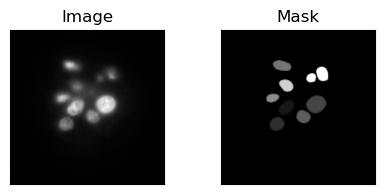

In [13]:
## Check that images and masks (labels) are loading appropriately
random.seed(120)
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(5, 2))

# Plot the first image on the left
axes[0].imshow(np.array(example_image))  #Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(np.array(example_mask), cmap='gray')
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()



### Fine-tuning

In [15]:
def get_bounding_box(ground_truth_map):
    """
    Compute the bounding box coordinates from a binary mask.
    
    Args:
        ground_truth_map (numpy.ndarray): 2D binary mask where objects are represented by values > 0.
    
    Returns:
        list: Bounding box coordinates [x_min, y_min, x_max, y_max].
              If no object is found, returns an empty list.
    """
    # Validate input type
    if not isinstance(ground_truth_map, np.ndarray):
        raise TypeError("Input must be a NumPy array.")

    # Find coordinates of nonzero pixels
    y_indices, x_indices = np.where(ground_truth_map > 0)
    
    # If no foreground pixels exist, return an empty list
    if len(x_indices) == 0 or len(y_indices) == 0:
        return []

    # Compute bounding box coordinates
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    # Get height and width of the image
    H, W = ground_truth_map.shape

    # Apply random perturbation to bounding box coordinates
    x_min = max(0, x_min - np.random.randint(0, 20))  # Ensure within image bounds
    x_max = min(W - 1, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H - 1, y_max + np.random.randint(0, 20))

    return [x_min, y_min, x_max, y_max]

In [16]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    """
    A custom PyTorch Dataset for processing images and masks.
    
    This dataset:
    - Loads images and corresponding segmentation masks.
    - Extracts bounding box prompts from the masks.
    - Processes images and bounding box prompts for model input.
    
    Args:
        dataset (list or Dataset): A dataset containing image-label pairs.
        processor (callable): A processor that prepares the images and prompts for the model.
    """
    def __init__(self, dataset, processor):
        if dataset is None or processor is None:
            raise ValueError("Both 'dataset' and 'processor' must be provided.")
        
        self.dataset = dataset
        self.processor = processor

    def __len__(self) -> int:
        """Returns the total number of samples in the dataset."""
        return len(self.dataset)

    def __getitem__(self, idx: int) -> dict:
        """
        Retrieves a sample from the dataset at index `idx` and processes it.
        
        Args:
            idx (int): Index of the sample.

        Returns:
            dict: Processed image, bounding box prompt, and ground truth mask.
        """
        item = self.dataset[idx]
        
        # Ensure required keys exist in dataset
        if "image" not in item or "label" not in item:
            raise KeyError("Dataset item must contain 'image' and 'label' keys.")

        image = item["image"]
        ground_truth_mask = np.array(item["label"])

        # Get bounding box from the mask
        prompt = get_bounding_box(ground_truth_mask)

        # If no valid bounding box is found, return empty inputs
        if not prompt:
            raise ValueError(f"No bounding box found for index {idx}. Check input mask.")

        # Prepare image and prompt using the processor
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension added by the processor
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add ground truth mask to the dictionary
        inputs["ground_truth_mask"] = torch.tensor(ground_truth_mask, dtype=torch.float32)

        return inputs


In [17]:
from transformers import SamProcessor

# Try to load the pre-trained processor, handle errors if needed
try:
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    print("Processor successfully loaded!")
except Exception as e:
    print(f"Error loading processor: {e}")


Processor successfully loaded!


In [18]:
# Create an instance of SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

print(f"SAMDataset successfully created with {len(train_dataset)} samples.")

SAMDataset successfully created with 2203 samples.


In [19]:
from torch.utils.data import DataLoader

# Create a DataLoader instance for training
train_dataloader = DataLoader(
    train_dataset,  # The dataset to load from
    batch_size=5,   # Number of samples per batch
    shuffle=True,   # Randomly shuffle data at every epoch for better training
    drop_last=False # Keep the last batch even if it's smaller than batch_size
)


In [20]:
batch = next(iter(train_dataloader))  # Get the first batch from the DataLoader

for k, v in batch.items():
    print(k, v.shape)  # Print key (tensor name) and its shape


pixel_values torch.Size([5, 3, 1024, 1024])
original_sizes torch.Size([5, 2])
reshaped_input_sizes torch.Size([5, 2])
input_boxes torch.Size([5, 1, 4])
ground_truth_mask torch.Size([5, 256, 256])


In [21]:
from transformers import SamModel

# Load the SAM model (pretrained weights from Facebook's SAM-ViT)
model = SamModel.from_pretrained("facebook/sam-vit-base")

In [22]:
# Freeze parameters for the vision encoder and prompt encoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)  # Freezes these parameters

In [23]:
from torch.optim import Adam

# Initialize the optimizer (only for the mask decoder)
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)


In [24]:
import monai

# Define the segmentation loss function (Dice + Focal Loss)
seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, squared_pred=True, reduction='mean')


In [25]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

# Training Configuration
num_epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)  # Move model to the appropriate device

# Set model to training mode
model.train()

# Training Loop
for epoch in range(num_epochs):
    epoch_losses = []  # Store loss values for this epoch

    # Iterate over batches
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Forward Pass
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),  # Move images to device
            input_boxes=batch["input_boxes"].to(device),    # Move input boxes to device
            multimask_output=False  # Single mask prediction
        )

        # Compute Loss
        predicted_masks = outputs.pred_masks.squeeze(1)  # Remove unnecessary dimension
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)  # Move masks to device
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))  # Compute segmentation loss

        epoch_losses.append(loss.item())  # Store loss for tracking

        # Backward Pass (Compute Gradients)
        optimizer.zero_grad()  # Reset gradients before each step
        loss.backward()  # Compute gradients

        # Update Model Parameters
        optimizer.step()  

    # Print Epoch Summary
    print(f'Mean loss: {mean(epoch_losses)}')


Epoch 1/5: 100%|████████████████████████████| 441/441 [2:38:17<00:00, 21.54s/it]


Mean loss: 0.7385605025588791


Epoch 2/5: 100%|████████████████████████████| 441/441 [2:38:05<00:00, 21.51s/it]


Mean loss: 0.7275592321846761


Epoch 3/5: 100%|████████████████████████████| 441/441 [2:41:56<00:00, 22.03s/it]


Mean loss: 0.7233005453264362


Epoch 4/5: 100%|████████████████████████████| 441/441 [2:40:43<00:00, 21.87s/it]


Mean loss: 0.7215762852000541


Epoch 5/5: 100%|████████████████████████████| 441/441 [2:40:54<00:00, 21.89s/it]

Mean loss: 0.720701097766288


In [26]:
# Get the current working directory
checkpoint_path = os.path.join(os.getcwd(), "finetuned_model_checkpoint.pth")

# Save the model's state dictionary
torch.save(model.state_dict(), checkpoint_path)

## Inference 

In [28]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
# Load the pretrained model
pretrained_model = SamModel.from_pretrained("facebook/sam-vit-base")
pretrained_model.to(device)
pretrained_model.eval()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [30]:
# Load the fine-tuned model
finetuned_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

finetuned_model = SamModel(config=finetuned_config)
checkpoint_path = os.path.join(os.getcwd(), "finetuned_model_checkpoint.pth")
finetuned_model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
finetuned_model.to(device)
finetuned_model.eval()


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

### Testing on one training image

In [32]:
# Select a random example from the training dataset
random.seed(12)
idx = random.randint(0, filtered_images.shape[0] - 1)

# Load image and label
test_image = dataset[idx]["image"]
test_label = dataset[idx]["label"]


#### Use grid points as prmopts 

In [34]:
def generate_grid_points(array_size=256, grid_size=10):
    """
    Generates a grid of 2D spatial points for prompt encoding.

    Parameters:
    - array_size (int): The size of the image (height/width).
    - grid_size (int): The number of grid points along each axis.

    Returns:
    - torch.Tensor: A tensor of shape (1, 1, grid_size * grid_size, 2)
      representing the input points for the model.
    """

    # Generate evenly spaced grid points
    x = np.linspace(0, array_size - 1, grid_size)
    y = np.linspace(0, array_size - 1, grid_size)

    # Create a grid of coordinates
    xv, yv = np.meshgrid(x, y)

    # Convert to integer lists
    grid_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv.tolist(), yv.tolist())]

    # Reshape to match the expected input tensor shape: (batch_size, point_batch_size, num_points_per_image, 2)
    input_points_tensor = torch.tensor(grid_points).view(1, 1, grid_size * grid_size, 2)

    return input_points_tensor

# Set parameters
ARRAY_SIZE = 256
GRID_SIZE = 10

# Generate input points
input_points = generate_grid_points(ARRAY_SIZE, GRID_SIZE)

# Print shape to verify correctness
print(f"Generated input_points shape: {input_points.shape}")

Generated input_points shape: torch.Size([1, 1, 100, 2])


In [35]:
# Prepare input for the model
inputs = processor(test_image, input_points=input_points, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}


In [36]:
# Forward pass for pretrained model
with torch.no_grad():
    pretrained_outputs = pretrained_model(**inputs, multimask_output=False)

# Forward pass for fine-tuned model
with torch.no_grad():
    finetuned_outputs = finetuned_model(**inputs, multimask_output=False)

# Apply sigmoid activation to get probability maps
finetuned_prob = torch.sigmoid(finetuned_outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
pretrained_prob = torch.sigmoid(pretrained_outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()

# Convert soft masks to hard masks
finetuned_seg = (finetuned_prob > 0.8).astype(np.uint8)
pretrained_seg = (pretrained_prob > 0.8).astype(np.uint8)

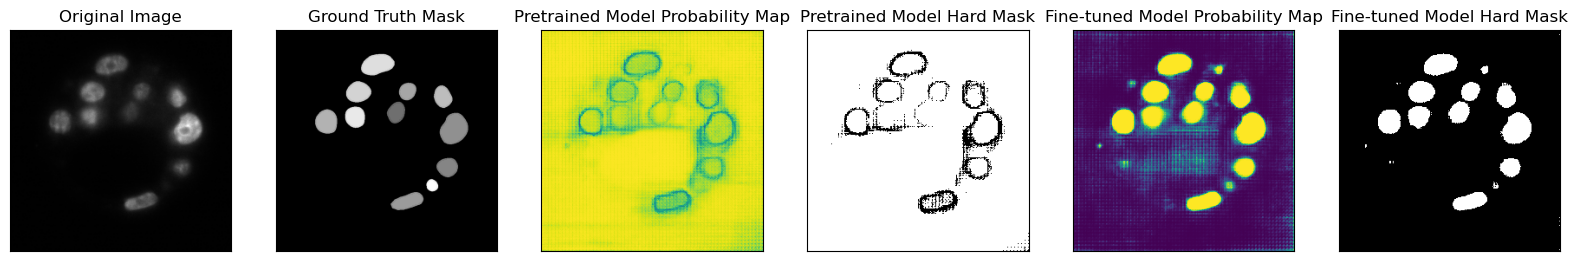

In [37]:
# Plot comparison
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Original Image")

axes[1].imshow(np.array(test_label), cmap='gray')
axes[1].set_title("Ground Truth Mask")

axes[2].imshow(pretrained_prob)
axes[2].set_title("Pretrained Model Probability Map")

axes[3].imshow(pretrained_seg, cmap='gray')
axes[3].set_title("Pretrained Model Hard Mask")

axes[4].imshow(finetuned_prob)
axes[4].set_title("Fine-tuned Model Probability Map")

axes[5].imshow(finetuned_seg, cmap='gray')
axes[5].set_title("Fine-tuned Model Hard Mask")

# Remove axis labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Show the plot
plt.show()


#### Use bounding box as prmopt

In [39]:
# Generate box prompt from the ground truth mask
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# Prepare input for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}


In [40]:
# Forward pass for pretrained model
with torch.no_grad():
    pretrained_outputs = pretrained_model(**inputs, multimask_output=False)

# Forward pass for fine-tuned model
with torch.no_grad():
    finetuned_outputs = finetuned_model(**inputs, multimask_output=False)

# Apply sigmoid activation to get probability maps
finetuned_prob = torch.sigmoid(finetuned_outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
pretrained_prob = torch.sigmoid(pretrained_outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()

# Convert soft masks to hard masks
finetuned_seg = (finetuned_prob > 0.8).astype(np.uint8)
pretrained_seg = (pretrained_prob > 0.8).astype(np.uint8)

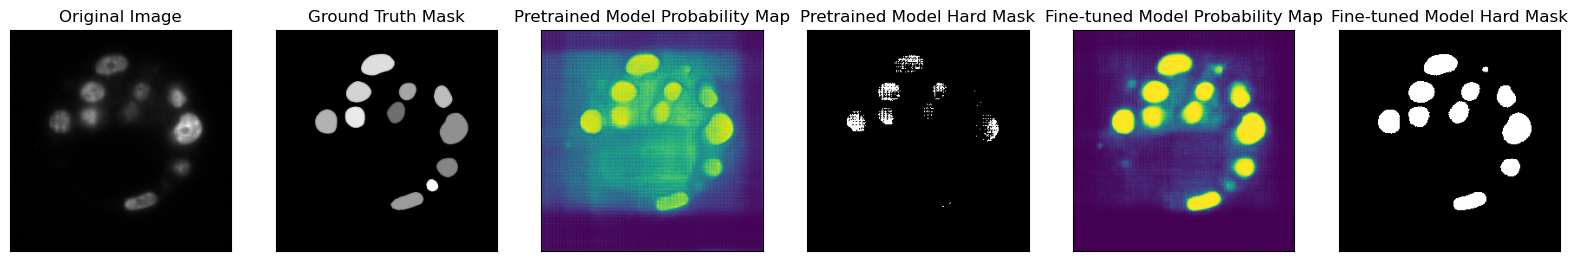

In [41]:
# Plot comparison
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Original Image")

axes[1].imshow(np.array(test_label), cmap='gray')
axes[1].set_title("Ground Truth Mask")

axes[2].imshow(pretrained_prob)
axes[2].set_title("Pretrained Model Probability Map")

axes[3].imshow(pretrained_seg, cmap='gray')
axes[3].set_title("Pretrained Model Hard Mask")

axes[4].imshow(finetuned_prob)
axes[4].set_title("Fine-tuned Model Probability Map")

axes[5].imshow(finetuned_seg, cmap='gray')
axes[5].set_title("Fine-tuned Model Hard Mask")

# Remove axis labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Show the plot
plt.show()


### Testing on the testing dataset 

In [43]:
m = 3  # Which image
n = 25  # Which slice

# Define the base directory (assuming you're inside 'nuclei_seg_mouse' folder)
base_dir = os.getcwd()

# Construct robust relative file paths
test_images_path = os.path.join(base_dir, "test_data_7", "intensity", f"intensity-{m:02d}.tif")
test_labels_path = os.path.join(base_dir, "test_data_7", "label", f"intensity-{m:02d}_3d_corr.tif")

# Read the images and labels
test_images = tifffile.imread(test_images_path)
test_labels = tifffile.imread(test_labels_path)

# Downsample test images
downsampled_test_images = np.zeros((test_images.shape[0], 256, 256))
for i in range(test_images.shape[0]):
    downsampled_test_images[i] = resize(test_images[i], (256, 256), anti_aliasing=True)
test_images = downsampled_test_images

# Downsample test masks
downsampled_test_labels = np.zeros((test_labels.shape[0], 256, 256))
for i in range(test_labels.shape[0]):
    downsampled_test_labels[i] = resize(test_labels[i], (256, 256), anti_aliasing=True)
test_labels = downsampled_test_labels

In [44]:
def generate_grid_points(array_size=256, grid_size=10):
    """
    Generates a grid of 2D spatial points for prompt encoding.

    Parameters:
    - array_size (int): The size of the image (height/width).
    - grid_size (int): The number of grid points along each axis.

    Returns:
    - torch.Tensor: A tensor of shape (1, 1, grid_size * grid_size, 2)
      representing the input points for the model.
    """

    # Generate evenly spaced grid points
    x = np.linspace(0, array_size - 1, grid_size)
    y = np.linspace(0, array_size - 1, grid_size)

    # Create a grid of coordinates
    xv, yv = np.meshgrid(x, y)

    # Convert to integer lists
    grid_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv.tolist(), yv.tolist())]

    # Reshape to match the expected input tensor shape: (batch_size, point_batch_size, num_points_per_image, 2)
    input_points_tensor = torch.tensor(grid_points).view(1, 1, grid_size * grid_size, 2)

    return input_points_tensor

# Set parameters
ARRAY_SIZE = 256
GRID_SIZE = 10

# Generate input points
input_points = generate_grid_points(ARRAY_SIZE, GRID_SIZE)

# Print shape to verify correctness
print(f"Generated input_points shape: {input_points.shape}")

Generated input_points shape: torch.Size([1, 1, 100, 2])


In [45]:
# Function to convert each slice to an RGB image
def convert_to_rgb(image_slice):
    image_rgb = np.stack([image_slice]*3, axis=-1)  # Replicate the grayscale image across 3 channels
    return Image.fromarray((image_rgb * 255).astype(np.uint8))  # Ensure the array is in the right format for an image

# Convert each slice of the downsampled test_images to RGB
converted_test_images = [convert_to_rgb(downsampled_test_images[i]) for i in range(downsampled_test_images.shape[0])]

# Verify the conversion by checking one of the images
print(type(converted_test_images[0]))  # Should be <class 'PIL.Image.Image'>
print(converted_test_images[0].mode)   # Should be 'RGB'
print(converted_test_images[0].size)   # Should be (256, 256)

converted_test_images = converted_test_images[n]

<class 'PIL.Image.Image'>
RGB
(256, 256)


In [46]:
# Use grid points as prompts
inputs = processor(converted_test_images, input_points=input_points, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

In [47]:
# Forward pass for pretrained model
with torch.no_grad():
    pretrained_outputs = pretrained_model(**inputs, multimask_output=False)

# Forward pass for fine-tuned model
with torch.no_grad():
    finetuned_outputs = finetuned_model(**inputs, multimask_output=False)

# Apply sigmoid activation to get probability maps
finetuned_prob = torch.sigmoid(finetuned_outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
pretrained_prob = torch.sigmoid(pretrained_outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()

# Convert soft masks to hard masks
finetuned_seg = (finetuned_prob > 0.8).astype(np.uint8)
pretrained_seg = (pretrained_prob > 0.8).astype(np.uint8)

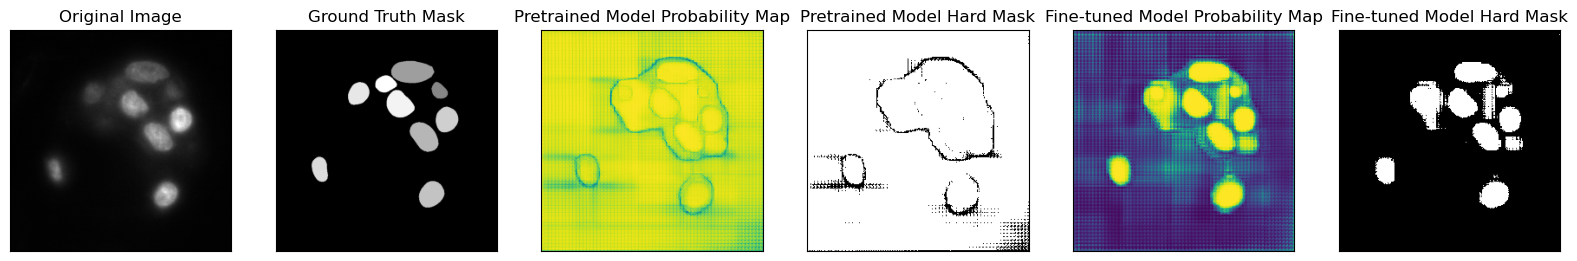

In [48]:
# Plot comparison
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

axes[0].imshow(np.array(test_images[n]), cmap='gray')
axes[0].set_title("Original Image")

axes[1].imshow(np.array(test_labels[n]), cmap='gray')
axes[1].set_title("Ground Truth Mask")

axes[2].imshow(pretrained_prob)
axes[2].set_title("Pretrained Model Probability Map")

axes[3].imshow(pretrained_seg, cmap='gray')
axes[3].set_title("Pretrained Model Hard Mask")

axes[4].imshow(finetuned_prob)
axes[4].set_title("Fine-tuned Model Probability Map")

axes[5].imshow(finetuned_seg, cmap='gray')
axes[5].set_title("Fine-tuned Model Hard Mask")

# Remove axis labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Show the plot
plt.show()
